# Application report

In [1]:
import telegram
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pandahouse
import io
import os
from datetime import date
from datetime import timedelta

sns.set()
plt.rc('date.autoformatter', day='%b %d')

In [2]:
def application_report(chat=None):
    chat_id = 958349291
    bot = telegram.Bot(token=os.environ.get("report_bot_token"))
    report_day = (date.today() - timedelta(days = 1)).strftime("%B %d, %Y")
    report_day_1 = (date.today() - timedelta(days = 7)).strftime("%Y, %B %d")
    report_day_7 = (date.today() - timedelta(days = 1)).strftime("%d")
        
    # Choose days
    today = pd.Timestamp('now') - pd.DateOffset(days=1)
    day_ago = today - pd.DateOffset(days=1)
    week_ago = today - pd.DateOffset(days=7)
    
    # Connection
    connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
    }
    
    # Get the data
    #  FM
    query1 = """
    SELECT 
    date, 
    COUNT(DISTINCT user_id) as users, 
    uniqExactIf(user_id, os='iOS') as users_i, 
    uniqExactIf(user_id, os='Android') as users_A
    FROM (
        SELECT DISTINCT
        toDate(time) as date, user_id, os
        FROM simulator_20220220.feed_actions
        WHERE toDate(time) between today() - 8 and today() - 1
        UNION ALL
        SELECT DISTINCT
        toDate(time) as date, user_id, os
        FROM simulator_20220220.message_actions
        WHERE toDate(time) between today() - 8 and today() - 1
        ) AS t
     GROUP BY date
     ORDER BY date DESC
    """
    FM = pandahouse.read_clickhouse(query1, connection=connection)
    FM['date'] = pd.to_datetime(FM['date']).dt.date
     
    # FEED    
    query2 = """
    SELECT
    toDate(time) as date,
    COUNT(DISTINCT user_id) as users_feed,
    countIf(user_id, action='view') as views,
    countIf(user_id, action='like') as likes,
    likes / views as CTR
    FROM simulator_20220220.feed_actions
    WHERE toDate(time) between today() - 8 and today() - 1
    GROUP BY date
    ORDER BY date DESC
    """
    F = pandahouse.read_clickhouse(query2, connection=connection)
    F['date'] = pd.to_datetime(F['date']).dt.date
    
    # MESSENGER
    query3 = """
     SELECT 
     toDate(time) as date,
     COUNT(DISTINCT user_id) as dau_msg, 
     count(user_id) as messages, 
     messages / dau_msg as MPU
     FROM simulator_20220220.message_actions
     WHERE toDate(time) between today() - 8 and today() - 1
     GROUP BY date
     ORDER BY date DESC
     """
    M = pandahouse.read_clickhouse(query3, connection=connection)
    M['date'] = pd.to_datetime(M['date']).dt.date
    
    # New Users
    query4 = """ SELECT
    date, COUNT(DISTINCT user_id) as new_users,
    uniqExactIf(user_id, source = 'ads') as new_users_ads,
    uniqExactIf(user_id, source = 'organic') as new_users_organic
    FROM (
        SELECT
            user_id,
            source,
            min(min_dt) as date
        FROM (                     
            SELECT 
                user_id, min(toDate(time)) as min_dt, source                            
            FROM simulator_20220220.feed_actions
            WHERE toDate(time) between today() - 90 and today() - 1
            GROUP BY user_id, source
            UNION ALL
            SELECT
                user_id, min(toDate(time)) as min_dt, source                            
            FROM simulator_20220220.message_actions
            WHERE toDate(time) between today() - 90 and today() - 1
            GROUP BY user_id, source) AS t
        GROUP BY user_id, source) AS tab
        WHERE date BETWEEN today() - 8 AND today() - 1
        GROUP BY date
        ORDER BY date DESC
        """
    NEW = pandahouse.read_clickhouse(query4, connection=connection)
    NEW['date'] = pd.to_datetime(NEW['date']).dt.date
    
    # Change types to int
    FM = FM.astype({'users': int, 'users_i': int, 'users_A': int}) 
    F = F.astype({'users_feed': int, 'views': int, 'likes': int})
    M = M.astype({'dau_msg': int, 'messages': int})
    NEW = NEW.astype({'new_users': int, 'new_users_ads': int, 'new_users_organic': int})

    # Feed+Messenger: DAU, DAU iOS, DAU Android
    users = FM[FM['date'] == today.date()]['users'].iloc[0]
    users_i = FM[FM['date'] == today.date()]['users_i'].iloc[0]
    users_A = FM[FM['date'] == today.date()]['users_A'].iloc[0]
    # day ago
    users_dayago = ((FM[FM['date'] == today.date()]['users'].iloc[0] - FM[FM['date'] == day_ago.date()]['users'].iloc[0])
                    / FM[FM['date'] == day_ago.date()]['users'].iloc[0])
    users_i_dayago = ((FM[FM['date'] == today.date()]['users_i'].iloc[0] - FM[FM['date'] == day_ago.date()]['users_i'].iloc[0])
                      /FM[FM['date'] == day_ago.date()]['users_i'].iloc[0])
    users_A_dayago = ((FM[FM['date'] == today.date()]['users_A'].iloc[0] - FM[FM['date'] == day_ago.date()]['users_A'].iloc[0])
                      /FM[FM['date'] == day_ago.date()]['users_A'].iloc[0])
    # week ago
    users_weekago = ((FM[FM['date'] == today.date()]['users'].iloc[0] - FM[FM['date'] == week_ago.date()]['users'].iloc[0])
                    /FM[FM['date'] == week_ago.date()]['users'].iloc[0])
    users_i_weekago = ((FM[FM['date'] == today.date()]['users_i'].iloc[0] - FM[FM['date'] == week_ago.date()]['users_i'].iloc[0])
                      /FM[FM['date'] == week_ago.date()]['users_i'].iloc[0])
    users_A_weekago = ((FM[FM['date'] == today.date()]['users_A'].iloc[0] - FM[FM['date'] == week_ago.date()]['users_A'].iloc[0])
                      /FM[FM['date'] == week_ago.date()]['users_A'].iloc[0])

    # Feed: DAU_feed, views, likes, ctr
    dau_feed = F[F['date'] == today.date()]['users_feed'].iloc[0]
    views =  F[F['date'] == today.date()]['views'].iloc[0]
    likes = F[F['date'] == today.date()]['likes'].iloc[0]
    ctr = F[F['date'] == today.date()]['CTR'].iloc[0]
    # day ago
    dau_feed_dayago = ((F[F['date'] == today.date()]['users_feed'].iloc[0] - F[F['date'] == day_ago.date()]['users_feed'].iloc[0])
                      / F[F['date'] == day_ago.date()]['users_feed'].iloc[0])
    views_dayago = ((F[F['date'] == today.date()]['views'].iloc[0] - F[F['date'] == day_ago.date()]['views'].iloc[0])
                    /F[F['date'] == day_ago.date()]['views'].iloc[0])    
    likes_dayago = ((F[F['date'] == today.date()]['likes'].iloc[0] - F[F['date'] == day_ago.date()]['likes'].iloc[0])
                    /F[F['date'] == day_ago.date()]['likes'].iloc[0])
    ctr_dayago = ((F[F['date'] == today.date()]['CTR'].iloc[0] - F[F['date'] == day_ago.date()]['CTR'].iloc[0])
                  /F[F['date'] == day_ago.date()]['CTR'].iloc[0])
    # week ago
    dau_feed_weekago = ((F[F['date'] == today.date()]['users_feed'].iloc[0] - F[F['date'] == week_ago.date()]['users_feed'].iloc[0])
                        /F[F['date'] == week_ago.date()]['users_feed'].iloc[0])
    views_weekago =  ((F[F['date'] == today.date()]['views'].iloc[0] - F[F['date'] == week_ago.date()]['views'].iloc[0])
                      /F[F['date'] == week_ago.date()]['views'].iloc[0])
    likes_weekago =  ((F[F['date'] == today.date()]['likes'].iloc[0] - F[F['date'] == week_ago.date()]['likes'].iloc[0])
                      /F[F['date'] == week_ago.date()]['likes'].iloc[0])
    ctr_weekago = ((F[F['date'] == today.date()]['CTR'].iloc[0] - F[F['date'] == week_ago.date()]['CTR'].iloc[0])
                   /F[F['date'] == week_ago.date()]['CTR'].iloc[0])
    
    # Messenger: DAU_msg, Messages, MPU
    dau_msg = M[M['date'] == today.date()]['dau_msg'].iloc[0]
    messages = M[M['date'] == today.date()]['messages'].iloc[0]
    mpu = M[M['date'] == today.date()]['MPU'].iloc[0]
    # day ago
    dau_msg_dayago = ((M[M['date'] == today.date()]['dau_msg'].iloc[0] - M[M['date'] == day_ago.date()]['dau_msg'].iloc[0])
                      /M[M['date'] == day_ago.date()]['dau_msg'].iloc[0])
    messages_dayago = ((M[M['date'] == today.date()]['messages'].iloc[0] - M[M['date'] == day_ago.date()]['messages'].iloc[0])
                       /M[M['date'] == day_ago.date()]['messages'].iloc[0])
    mpu_dayago = ((M[M['date'] == today.date()]['MPU'].iloc[0] - M[M['date'] == day_ago.date()]['MPU'].iloc[0])
                  /M[M['date'] == day_ago.date()]['MPU'].iloc[0])
    # week ago
    dau_msg_weekago = ((M[M['date'] == today.date()]['dau_msg'].iloc[0] - M[M['date'] == week_ago.date()]['dau_msg'].iloc[0])
                       /M[M['date'] == week_ago.date()]['dau_msg'].iloc[0])
    messages_weekago = ((M[M['date'] == today.date()]['messages'].iloc[0] - M[M['date'] == week_ago.date()]['messages'].iloc[0])
                        /M[M['date'] == week_ago.date()]['messages'].iloc[0])
    mpu_weekago = ((M[M['date'] == today.date()]['MPU'].iloc[0] - M[M['date'] == week_ago.date()]['MPU'].iloc[0])
                   /M[M['date'] == week_ago.date()]['MPU'].iloc[0])
    
    # NEW users: new_total, new_ads, new_organic
    new_users = NEW[NEW['date'] == today.date()]['new_users'].iloc[0]
    new_users_ads = NEW[NEW['date'] == today.date()]['new_users_ads'].iloc[0]
    new_users_organic = NEW[NEW['date'] == today.date()]['new_users_organic'].iloc[0]
    # day ago
    new_users_dayago = ((NEW[NEW['date'] == today.date()]['new_users'].iloc[0] - NEW[NEW['date'] == day_ago.date()]['new_users'].iloc[0])
                        /NEW[NEW['date'] == day_ago.date()]['new_users'].iloc[0])
    new_users_ads_dayago = ((NEW[NEW['date'] == today.date()]['new_users_ads'].iloc[0] - NEW[NEW['date'] == day_ago.date()]['new_users_ads'].iloc[0])
                      /NEW[NEW['date'] == day_ago.date()]['new_users_ads'].iloc[0])
    new_users_organic_dayago = ((NEW[NEW['date'] == today.date()]['new_users_organic'].iloc[0] - NEW[NEW['date'] == day_ago.date()]['new_users_organic'].iloc[0])
                          /NEW[NEW['date'] == day_ago.date()]['new_users_organic'].iloc[0])
    # week ago
    new_users_weekago = ((NEW[NEW['date'] == today.date()]['new_users'].iloc[0] - NEW[NEW['date'] == week_ago.date()]['new_users'].iloc[0])
                         /NEW[NEW['date'] == week_ago.date()]['new_users'].iloc[0])
    new_users_ads_weekago = ((NEW[NEW['date'] == today.date()]['new_users_ads'].iloc[0] - NEW[NEW['date'] == week_ago.date()]['new_users_ads'].iloc[0])
                       /NEW[NEW['date'] == week_ago.date()]['new_users_ads'].iloc[0])
    new_users_organic_weekago = ((NEW[NEW['date'] == today.date()]['new_users_organic'].iloc[0] - NEW[NEW['date'] == week_ago.date()]['new_users_organic'].iloc[0])
                           /NEW[NEW['date'] ==week_ago.date()]['new_users_organic'].iloc[0])
        
    # Message text    
    message_text = f"""
    *Application Report {report_day_1}-{report_day_7}*\n
    👥DAU: {users} ({users_dayago:+.2%} DoD, {users_weekago:+.2%} WoW)
    👥by platform:
        🍏iOS: {users_i} ({users_i_dayago:+.2%} DoD, {users_i_weekago:+.2%} WoW)
        🤖Android: {users_A} ({users_A_dayago:+.2%} DoD, {users_A_weekago:+.2%} WoW)
   
    👤New users: {new_users} ({new_users_dayago:+.2%} DoD, {new_users_weekago:+.2%} WoW)
    👤by source:
        🧲ads: {new_users_ads} ({new_users_ads_dayago:+.2%} DoD, {new_users_ads_weekago:+.2%} WoW)
        🥦organic: {new_users_organic} ({new_users_organic_dayago:+.2%} DoD, {new_users_organic_weekago:+.2%} WoW)
    
    *FEED:*  
    👥 DAU: {dau_feed} ({dau_feed_dayago:+.2%} DoD, {dau_feed_weekago:+.2%} WoW)
    👀 Views: {views} ({views_dayago:+.2%} DoD, {views_weekago:+.2%} WoW)
    👍 Likes: {likes} ({likes_dayago:+.2%} DoD, {likes_weekago:+.2%} WoW)
    🎯 CTR: {ctr:.3f} ({ctr_dayago:+.2%} DoD, {ctr_weekago:+.2%} WoW)
    
    *MESSENGER:*
    👥 DAU: {dau_msg} ({dau_msg_dayago:+.2%} DoD, {dau_msg_weekago:+.2%} WoW)
    ✉️ Messages: {messages} ({messages_dayago:+.2%} DoD, {messages_weekago:+.2%} WoW)
    📋 Messages per user: {mpu:.3f} ({mpu_dayago:+.2%} DoD, {mpu_weekago:+.2%} WoW)
    """        
    
    # PLOTS
    plots = []
    
    # APP Plots
    fig, axes = plt.subplots(ncols=2, figsize=(12,6))
    axes[0].set_title('DAU')
    axes[1].set_title('NEW Users')
    sns.lineplot(ax=axes[0], data=FM,  x='date', y='users_A').set_xlabel("Day", fontsize = 11)
    sns.lineplot(ax=axes[0], data=FM, x='date', y='users_i').set_xlabel("Day", fontsize = 11)
    axes[0].legend(['Android users CTR', 'iOS users'])
    axes[0].set(ylabel=None)

    sns.lineplot(ax=axes[1], data=NEW, x='date', y='new_users_ads', color='green').set_xlabel("Day", fontsize = 11)
    sns.lineplot(ax=axes[1], data=NEW, x='date', y='new_users_organic', color='blue').set_xlabel("Day", fontsize = 11)
    axes[1].legend(['users from Ads', 'Organic users'])
    axes[1].set(ylabel=None)
    fig.suptitle('Past 7 days report\nApplication')
    fig.tight_layout()
    
    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.name = 'app.png'
    plot_object.seek(0)
    plt.close()
    plots.append(plot_object)
 
    # FEED Plots
    plt.rc('date.autoformatter', day='%b %d')
    fig, axes = plt.subplots(2, 2, figsize=(12,8))
    axes[0, 0].set_title('DAU Feed')
    axes[0, 1].set_title('Number of Views')
    axes[1, 0].set_title('Number of Likes')
    axes[1, 1].set_title('CTR')
    sns.lineplot(ax=axes[0, 0], data=F, x='date', y='users_feed').set_xlabel("Day", fontsize = 11)
    sns.lineplot(ax=axes[0, 1], data=F,  x='date', y='views').set_xlabel("Day", fontsize = 11)
    sns.lineplot(ax=axes[1, 0], data=F, x='date', y='likes').set_xlabel("Day", fontsize = 11)
    sns.lineplot(ax=axes[1, 1], data=F, x='date', y='CTR').set_xlabel("Day", fontsize = 11)
    for ax in axes.flatten():
        ax.set(ylabel=None)
    fig.suptitle('Past 7 days report\nFeed')
    fig.tight_layout()

    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.name = 'feed.png'
    plot_object.seek(0)
    plt.close()
    plots.append(plot_object)
    
    # MESSAGE Plots
    fig, axes = plt.subplots(3, figsize=(10,8), sharex=True)
    axes[0].set_title('DAU Messenger')
    axes[1].set_title('Total messages')
    axes[2].set_title('Messages per User')
    sns.lineplot(ax=axes[0], data=M, x='date', y='dau_msg').set_xlabel("Day", fontsize = 11)
    sns.lineplot(ax=axes[1], data=M,  x='date', y='messages').set_xlabel("Day", fontsize = 11)
    sns.lineplot(ax=axes[2], data=M, x='date', y='MPU').set_xlabel("Day", fontsize = 11)
    for ax in axes.flatten():
        ax.set(ylabel=None)
    fig.suptitle('Past 7 days report\nMessenger')
    fig.tight_layout()

    plot_object = io.BytesIO()
    plt.savefig(plot_object)
    plot_object.name = 'messenger.png'
    plot_object.seek(0)
    plt.close()
    plots.append(plot_object)        
    
    # Send report
    for plot_object in plots:
        bot.sendPhoto(chat_id=chat_id, photo=plot_object)
    bot.sendMessage(chat_id=chat_id, text=message_text, parse_mode= 'Markdown')


In [ ]:
try:
    feed_messenger_report()
except Exception as e:
    print(e)

## Report


    *Application Report 2022, April 02-08*

    👥DAU: 20817 (-3.28% DoD, -4.23% WoW)
    👥by platform:
        🍏iOS: 7190 (-3.99% DoD, -5.34% WoW)
        🤖Android: 13627 (-2.90% DoD, -3.63% WoW)
   
    👤New users: 952 (-7.57% DoD, -14.31% WoW)
    👤by source:
        🧲ads: 950 (-6.95% DoD, -13.24% WoW)
        🥦organic: 2 (-77.78% DoD, -87.50% WoW)
    
    *FEED:*  
    👥 DAU: 18885 (+0.67% DoD, -1.36% WoW)
    👀 Views: 604637 (-3.54% DoD, -8.43% WoW)
    👍 Likes: 128146 (-2.45% DoD, -10.31% WoW)
    🎯 CTR: 0.212 (+1.13% DoD, -2.06% WoW)
    
    *MESSENGER:*
    👥 DAU: 2210 (-29.23% DoD, -24.75% WoW)
    ✉️ Messages: 12900 (-0.01% DoD, +0.01% WoW)
    📋 Messages per user: 5.837 (+41.30% DoD, +32.91% WoW)
    


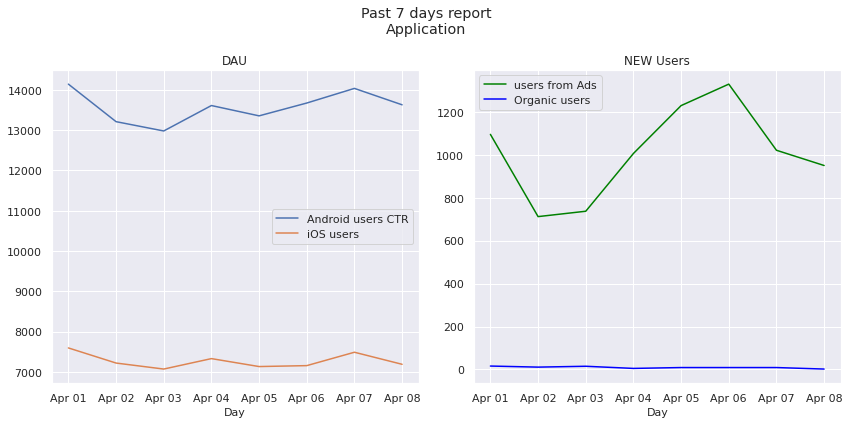

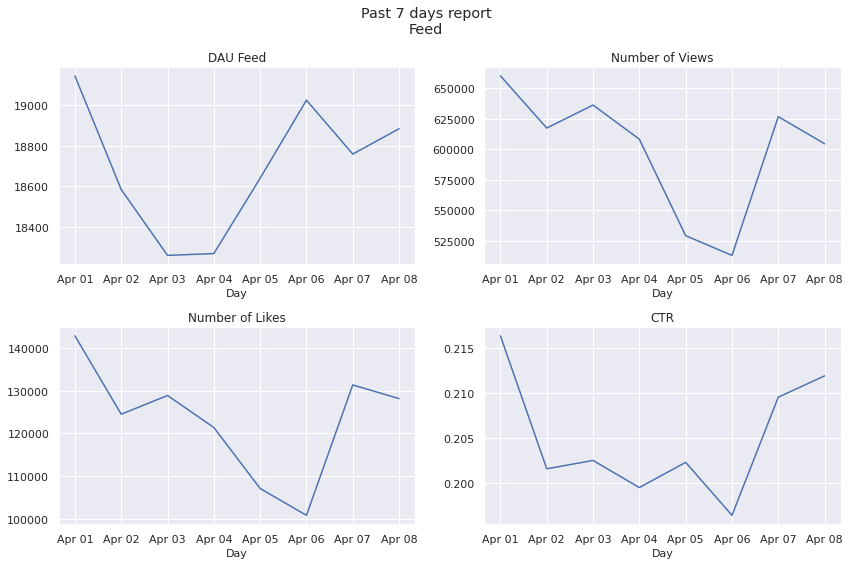

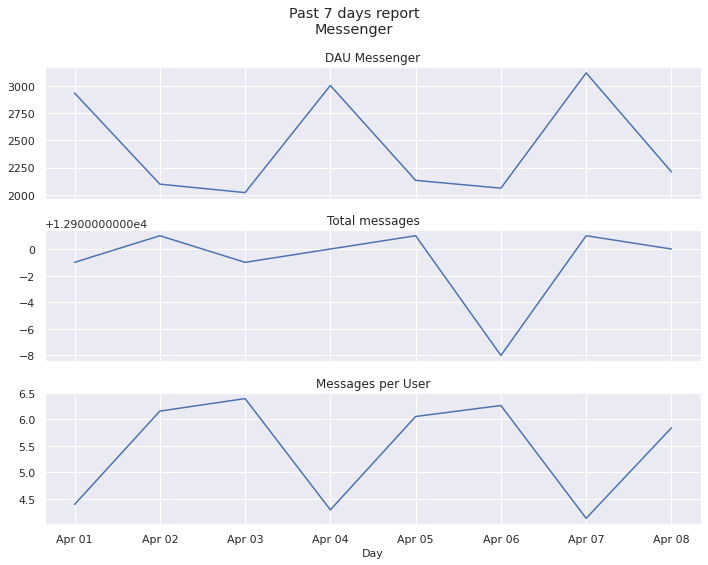

In [3]:
application_report()